Processing file: MsgTraces_different_0.tr
ERROR: Start entry of message (10.0.0.1:1000 > 10.0.6.1:1006, 96) not found!
ERROR: Start entry of message (10.0.0.1:1000 > 10.0.6.1:1006, 97) not found!
Number of uncompleted messages: 2
Number of distinct message sizes: 369
Number of distinct message sizes that have multiple measurements: 328
Number of distinct messages: 8220

Processing file: MsgTraces_same_0.tr
Number of uncompleted messages: 2
Number of distinct message sizes: 336
Number of distinct message sizes that have multiple measurements: 283
Number of distinct messages: 3911



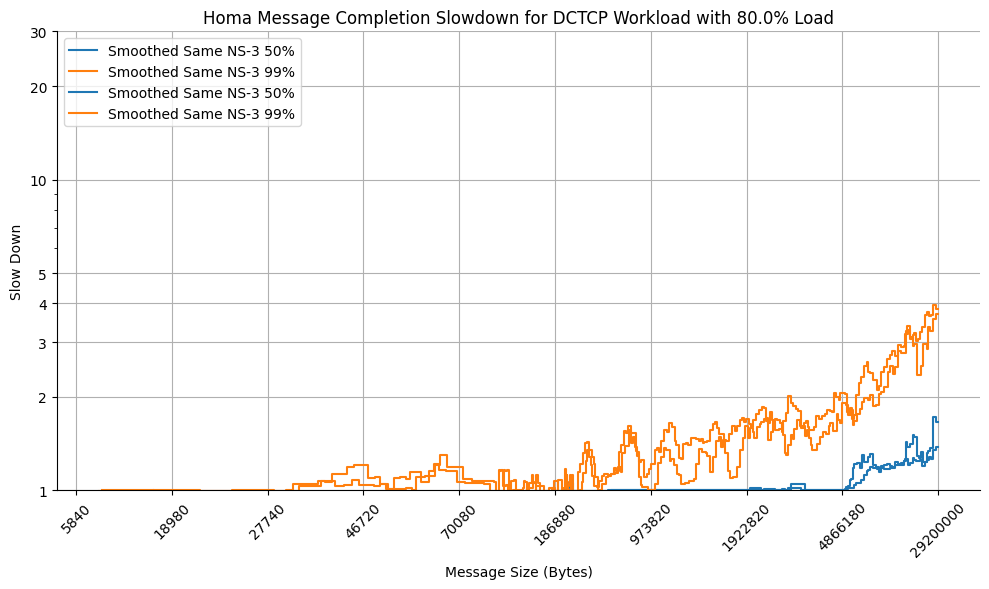

In [7]:
import json
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import random

# Constants
figsize = (10,6)
pktPayloadSize = 1460 # Bytes
hdrSize = 40 # Bytes
torBw = 10e9 # bps
coreBw = 40e9 # bps

# One-way delay calculations
oneWayDel = 1.0e-6 + (pktPayloadSize + hdrSize) * 8 * (2 / torBw + 2 / coreBw)
baseRtt = oneWayDel + 1.0e-6 + 64 * 8 * (2 / torBw + 2 / coreBw)
bdpPkts = 7
saturationTime = 3.1  # This value might need to be adjusted based on your specific context

workloadName = '_W5'
workloadSource = 'DCTCP'
networkLoad = 0.8
simName = workloadName + '_load-' + str(int(networkLoad*100)) + 'p'
numSim = 8
folderName = str(numSim)+"-parallel-sims-noRtx/"
# folderName = "./"
plotQueueFigures = False
saturationTime = 3.1

# Original Homa paper data
homaPercent = 0
origMsgSizeCumPercents = []
origP50SlowDowns = []
origP99SlowDowns = []
pfabricPercent = 0
pfabricMsgSizeCumPercents = []
pfabricP50SlowDowns = []
pfabricP99SlowDowns = []
with open("../../inputs/homa-paper-reproduction/original-raw-data-from-paper.txt",'r') as f:
    for line in f:
        rawEntry = line.split()
        
        protocol = rawEntry[0]
        if (protocol=='TransportType'):
            continue
            
        loadFactor = float(rawEntry[1])
        workload = rawEntry[2]
        sizeCntPercent = float(rawEntry[4])
        medianSlowDown = float(rawEntry[8]) if rawEntry[8]!='NA' else None
        tailSlowDown = float(rawEntry[9]) if rawEntry[9]!='NA' else None
        
        if (protocol == 'Homa' \
             and loadFactor == networkLoad \
             and workload == workloadSource \
             and (medianSlowDown or tailSlowDown)):
            
            if (medianSlowDown):
                homaPercent += sizeCntPercent 
                origMsgSizeCumPercents.append(homaPercent)
                origP50SlowDowns.append(medianSlowDown)
            elif (tailSlowDown):
                origP99SlowDowns.append(tailSlowDown)
                
        if (protocol == 'pFabric' \
             and loadFactor == networkLoad \
             and workload == workloadSource \
             and (medianSlowDown or tailSlowDown)):
            
            if (medianSlowDown):
                pfabricPercent += sizeCntPercent 
                pfabricMsgSizeCumPercents.append(pfabricPercent)
                pfabricP50SlowDowns.append(medianSlowDown)
            elif (tailSlowDown):
                pfabricP99SlowDowns.append(tailSlowDown)

# Function to remove a key from a dictionary
def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

# Function to process a single trace file
def process_trace_file(filename):
    msgStartEntryDict = {}
    msgCompletionTimesDict = {}
    allMsgSizes = []

    with open(filename, 'r') as f:
        for line in f:
            msgLog = line.split()

            time = float(msgLog[1])*1e-9        # in seconds
            msgSize = int(msgLog[2])            # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            key = (sender, receiver, txMsgId)

            if msgLog[0] == '+':
                if key in msgStartEntryDict:
                    msgStartEntryDict[key].append(time)
                else:
                    msgStartEntryDict[key] = [time]

            elif msgLog[0] == '-':
                if key in msgStartEntryDict:
                    startTime = msgStartEntryDict[key].pop()
                    if len(msgStartEntryDict[key]) <= 0:
                        msgStartEntryDict = removeKey(msgStartEntryDict, key)

                    if startTime < saturationTime:
                        continue
                
                    if msgSize in msgCompletionTimesDict:
                        msgCompletionTimesDict[msgSize].append(time - startTime)
                    else:
                        msgCompletionTimesDict[msgSize] = [time - startTime]
                    allMsgSizes.append(msgSize)
                else:
                    print('ERROR: Start entry of message (' \
                          + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                          + ') not found!')
    allMsgSizes = np.array(allMsgSizes)
    msgSizePercentiles = stats.rankdata(allMsgSizes, 'max')/len(allMsgSizes)*100

    # Number of uncompleted messages
    i = 0
    for msgKey, msgStartTimes in msgStartEntryDict.items():
        i += len(msgStartTimes)
    print ('Number of uncompleted messages: ' + str(i))

    print('Number of distinct message sizes: ' + str(len(msgCompletionTimesDict)))

    cntMultMeasures = 0
    numMsgs = 0
    nonFullPacketMsgSizes = []
    for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
        
        if (len(msgCompletionTimes)>1):
            cntMultMeasures += 1
        
        numMsgs += len(msgCompletionTimes)
        
        if (msgSize%pktPayloadSize != 0):
            nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
        
    print('Number of distinct message sizes that '\
        +'have multiple measurements: ' + str(cntMultMeasures))   
    print('Number of distinct messages: ' + str(numMsgs)) 

    if (nonFullPacketMsgSizes):
        print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)

    # Return the data structures that are needed for plotting
    return allMsgSizes, msgCompletionTimesDict, msgSizePercentiles


# Function to plot the data
def plot_data(allMsgSizes, msgCompletionTimesDict, msgSizePercentiles, label_prefix, plot_combined=False):
    # Get data
    SimMsgSizes = []
    SimP50CompletionTimes = []
    SimP99CompletionTimes = []
    SimBaseCompletionTimes = []
    SimP50SlowDowns = []
    SimP99SlowDowns = []

    for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
        # Ignore messages that have less than 10 measurements
        SimMsgSizes.append(msgSize)
        
        # Calculate completion times
        times = np.array(msgCompletionTimes)
        p50CompletionTime = np.percentile(times,50)
        SimP50CompletionTimes.append(p50CompletionTime)
        p99CompletionTime = np.percentile(times,99)
        SimP99CompletionTimes.append(p99CompletionTime)
        
        # Total bytes of message including its header
        totBytes = msgSize + math.ceil(msgSize / pktPayloadSize) * (hdrSize) 

        # Theoretical fastest completion time (bytes sent divided by link bandwidth)
        baseCompletionTime = totBytes * 8 / torBw;

        # Add the one-way delay for the first packet
        if (msgSize > bdpPkts * pktPayloadSize):
            baseCompletionTime += oneWayDel #baseRtt
        else:
            baseCompletionTime += oneWayDel
        
        # Add the one-way delay for the remaining packets
        SimBaseCompletionTimes.append(baseCompletionTime)
        
        # Calculate slowdowns
        SimP50SlowDowns.append(p50CompletionTime / baseCompletionTime)
        SimP99SlowDowns.append(p99CompletionTime / baseCompletionTime)
        
    zipData = sorted(zip(SimMsgSizes,
                        SimP50CompletionTimes,
                        SimP99CompletionTimes,
                        SimBaseCompletionTimes,
                        SimP50SlowDowns,
                        SimP99SlowDowns))

    SimMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])

    SimP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
    SimP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])

    SimBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])

    SimP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
    SimP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

    # Plotting steps
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    # Specify the window size for moving average
    window_size = 5  # Adjust this as needed

    # Data preparation
    x = [msgSizePercentiles[np.where(allMsgSizes == i)[0][0]] for i in SimMsgSizes]

    # Apply moving average
    smoothed_SimP50SlowDowns = moving_average(SimP50SlowDowns, window_size)
    smoothed_SimP99SlowDowns = moving_average(SimP99SlowDowns, window_size)

    # Adjust x-axis for smoothed data
    smoothed_x = x[window_size-1:]

    # List of common colors
    common_colors = ['red', 'yellow', 'green', 'blue', 'orange', 'purple', 'pink', 'gray', 'brown']

    # Select a random color from the list
    random_color = random.choice(common_colors)
    random_color2 = random.choice(common_colors)

    # Plotting steps with smoothed data
    plt.step(smoothed_x, smoothed_SimP50SlowDowns, label='Smoothed Same NS-3 50%', color=random_color)
    plt.step(smoothed_x, smoothed_SimP99SlowDowns, label='Smoothed Same NS-3 99%', color=random_color2)

    # Axes labels and title
    plt.ylabel('Slow Down')
    plt.xlabel('Message Size (Bytes)')
    plt.title('Homa Message Completion Slowdown for ' + \
            workloadSource + ' Workload with ' + \
            str(networkLoad * 100) + '% Load')

    # Set x-axis and y-axis
    xTickPercentiles = np.linspace(10, 100, 10)
    xticks = np.percentile(allMsgSizes, xTickPercentiles).astype(int)
    plt.xticks(xTickPercentiles, xticks, rotation=45)
    plt.yscale('log')

    # Y-axis scaling based on network load
    if networkLoad == 0.5:
        yticks = [1, 2, 3, 4, 5, 10, 15]
        plt.ylim([1, 15])
    elif networkLoad == 0.8:
        yticks = [1, 2, 3, 4, 5, 10, 20, 30]
        plt.ylim([1, 30])

    if yticks:
        plt.yticks(yticks, yticks)

    # Finalizing the figure
    plt.legend(loc='upper left')
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.tight_layout()

# Main script
filenames = ["MsgTraces_different_0.tr", "MsgTraces_same_0.tr"]  # List of filenames to process
combined_allMsgSizes = []
combined_msgCompletionTimesDict = {}

plt.figure(figsize=figsize)
plt.grid()
for filename in filenames:
    print("Processing file: " + filename)
    allMsgSizes, msgCompletionTimesDict, msgSizePercentiles = process_trace_file(filename)
    combined_allMsgSizes.extend(allMsgSizes)
    # Combine the dictionaries (you might need to adjust this part based on your data structure)
    for key, value in msgCompletionTimesDict.items():
        if key in combined_msgCompletionTimesDict:
            combined_msgCompletionTimesDict[key].extend(value)
        else:
            combined_msgCompletionTimesDict[key] = value

    plot_data(allMsgSizes, msgCompletionTimesDict, msgSizePercentiles, label_prefix=filename)
    print()
plt.show()

# Optionally, create a combined plot
# plot_data(combined_allMsgSizes, combined_msgCompletionTimesDict, label_prefix="Combined", plot_combined=True)
